In [10]:
import numpy as np
import json
import collections
import matplotlib.pyplot as plt

In [11]:
def data_processing(data):
	train_set, valid_set, test_set = data['train_data'], data['val_data'], data['test_data']
	Xtrain = train_set["features"]
	ytrain = train_set["labels"]
	Xval = valid_set["features"]
	yval = valid_set["labels"]
	Xtest = test_set["features"]
	ytest = test_set["labels"]

	Xtrain = np.array(Xtrain)
	Xval = np.array(Xval)
	Xtest = np.array(Xtest)

	ytrain = np.array(ytrain)
	yval = np.array(yval)
	ytest = np.array(ytest)
	
	return Xtrain, ytrain, Xval, yval, Xtest, ytest

In [12]:
def data_processing_with_transformation(data, do_minmax_scaling=True, do_normalization=False):
	train_set, valid_set, test_set = data['train_data'], data['val_data'], data['test_data']
	Xtrain = train_set["features"]
	ytrain = train_set["labels"]
	Xval = valid_set["features"]
	yval = valid_set["labels"]
	Xtest = test_set["features"]
	ytest = test_set["labels"]

	Xtrain = np.array(Xtrain)
	Xval = np.array(Xval)
	Xtest = np.array(Xtest)

	ytrain = np.array(ytrain)
	yval = np.array(yval)
	ytest = np.array(ytest)
	
	# We load data from json here and turn the data into numpy array
	# You can further perform data transformation on Xtrain, Xval, Xtest

	# Min-Max scaling
	def minmax_scaling(x, feature_min=None, feature_max=None):
		if feature_min is None or feature_max is None:
			feature_min = np.min(x, axis=0)
			feature_max = np.max(x, axis=0)
		return (x - feature_min) / (feature_max - feature_min), feature_min, feature_max

	if do_minmax_scaling:
		Xtrain, feature_min, feature_max = minmax_scaling(Xtrain)
		Xval, _, _ = minmax_scaling(Xval, feature_min, feature_max)
		Xtest, _, _ = minmax_scaling(Xtest, feature_min, feature_max)

	# Normalization
	def normalization(x):
		epsilon = 1e-10
		return x / (np.linalg.norm(x, ord=2, axis=0, keepdims=True) + epsilon)
		
	if do_normalization:
		Xtrain = normalization(Xtrain)
		Xval = normalization(Xval)
		Xtest = normalization(Xtest)

	return Xtrain, ytrain, Xval, yval, Xtest, ytest

In [13]:
def compute_l2_distances(Xtrain, X):
	"""
	Compute the distance between each test point in X and each training point
	in Xtrain.
	Inputs:
	- Xtrain: A numpy array of shape (num_train, D) containing training data
	- X: A numpy array of shape (num_test, D) containing test data.
	Returns:
	- dists: A numpy array of shape (num_test, num_train) where dists[i, j]
	  is the Euclidean distance between the ith test point and the jth training
	  point.
	"""
	num_train = Xtrain.shape[0]
	num_test = X.shape[0]
	dists = np.zeros((num_test, num_train))
	for i in range(num_test):
		for j in range(num_train):
			dists[i][j] = np.sqrt(np.sum((X[i] - Xtrain[j]) ** 2))
	return dists

In [14]:
def compute_cosine_distances(Xtrain, X):
	"""
	Compute the distance between each test point in X and each training point
	in Xtrain.
	Inputs:
	- Xtrain: A numpy array of shape (num_train, D) containing training data
	- X: A numpy array of shape (num_test, D) containing test data.
	Returns:
	- dists: A numpy array of shape (num_test, num_train) where dists[i, j]
	  is the Cosine distance between the ith test point and the jth training
	  point.
	"""
	epsilon = 1e-10
	num_test = X.shape[0]
	num_train = Xtrain.shape[0]
	dists = np.zeros((num_test, num_train))

	for i in range(num_test):
		for j in range(num_train):
			dists[i][j] = 1 - np.dot(X[i], Xtrain[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(Xtrain[j]) + epsilon)

	return dists

In [15]:
def predict_labels(k, ytrain, dists):
	"""
	Given a matrix of distances between test points and training points,
	predict a label for each test point.
	Inputs:
	- k: The number of nearest neighbors used for prediction.
	- ytrain: A numpy array of shape (num_train,) where ytrain[i] is the label
	  of the ith training point.
	- dists: A numpy array of shape (num_test, num_train) where dists[i, j]
	  gives the distance betwen the ith test point and the jth training point.
	Returns:
	- ypred: A numpy array of shape (num_test,) containing predicted labels for the
	  test data, where y[i] is the predicted label for the test point X[i].
	"""
	num_test = dists.shape[0]
	ypred = np.zeros(num_test)

	for i in range(num_test):
		k_closest_y = ytrain[np.argsort(dists[i])[:k]]
		labels, counts = np.unique(k_closest_y, return_counts=True)
		ypred[i] = labels[np.argmax(counts)]

	return ypred

In [16]:
def compute_error_rate(y, ypred):
	"""
	Compute the error rate of prediction based on the true labels.
	Inputs:
	- y: A numpy array with of shape (num_test,) where y[i] is the true label
	  of the ith test point.
	- ypred: A numpy array with of shape (num_test,) where ypred[i] is the
	  prediction of the ith test point.
	Returns:
	- err: The error rate of prediction (scalar).
	"""
	return np.mean(y != ypred)

In [17]:
def find_best_k(K, ytrain, dists, yval):
	"""
	Find best k according to validation error rate.
	Inputs:
	- K: A list of ks.
	- ytrain: A numpy array of shape (num_train,) where ytrain[i] is the label
	  of the ith training point.
	- dists: A numpy array of shape (num_test, num_train) where dists[i, j]
	  is the distance between the ith test point and the jth training
	  point.
	- yval: A numpy array with of shape (num_val,) where y[i] is the true label
	  of the ith validation point.
	Returns:
	- best_k: The k with the lowest error rate.
	- validation_error: A list of error rate of different ks in K.
	- best_err: The lowest error rate we get from all ks in K.
	"""
	validation_error = []
	for k in K:
		ypred = predict_labels(k, ytrain, dists)
		err = compute_error_rate(yval, ypred)
		validation_error.append(err)

	min_error_index = np.argmin(validation_error)
	best_k = K[min_error_index]
	best_err = validation_error[min_error_index]

	return best_k, validation_error, best_err

The validation error rate is 0.07692307692307693 in Problem Set 1.1

The validation error rate is 0.08791208791208792 in Problem Set 1.2 when using normalization

The validation error rate is 0.054945054945054944 in Problem Set 1.2 when using minmax_scaling

The validation error rate is 0.04395604395604396 in Problem Set 1.3, which use cosine distance



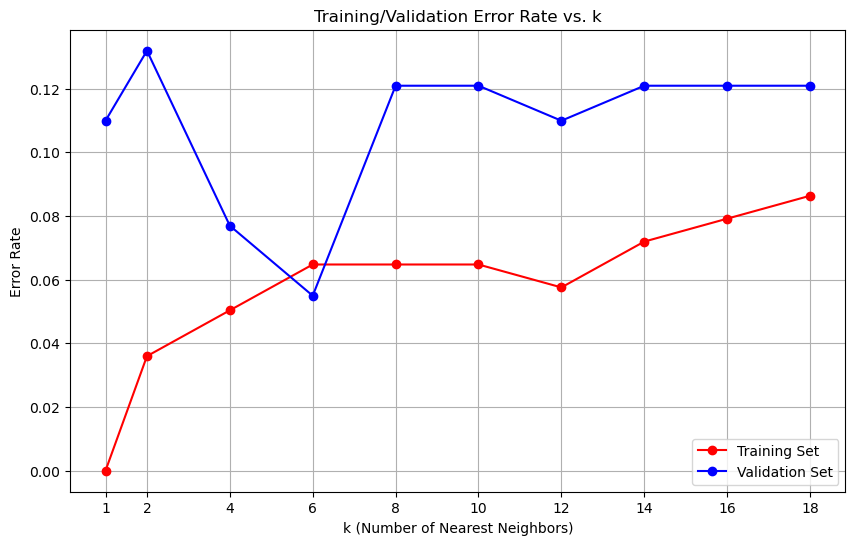

In Problem Set 1.4, we use the best k =  6 with the best validation error rate 0.054945054945054944
Using the best k, the final test error rate is 0.07100591715976332


In [18]:
def main():
	input_file = 'breast_cancer_dataset.json'
	output_file = 'knn_output.txt'

	#==================Problem Set 1.1=======================

	with open(input_file) as json_data:
		data = json.load(json_data)

	# Compute distance matrix
	Xtrain, ytrain, Xval, yval, Xtest, ytest = data_processing(data)

	dists = compute_l2_distances(Xtrain, Xval)

	# Compute validation accuracy when k=4
	k = 4
	ypred = predict_labels(k, ytrain, dists)
	err = compute_error_rate(yval, ypred)
	print("The validation error rate is", err, "in Problem Set 1.1")
	print()

	#==================Problem Set 1.2=======================

	# Compute distance matrix
	Xtrain, ytrain, Xval, yval, Xtest, ytest = data_processing_with_transformation(data, do_minmax_scaling=False, do_normalization=True)

	dists = compute_l2_distances(Xtrain, Xval)

	# Compute validation accuracy when k=4
	k = 4
	ypred = predict_labels(k, ytrain, dists)
	err = compute_error_rate(yval, ypred)
	print("The validation error rate is", err, "in Problem Set 1.2 when using normalization")
	print()

	# Compute distance matrix
	Xtrain, ytrain, Xval, yval, Xtest, ytest = data_processing_with_transformation(data, do_minmax_scaling=True, do_normalization=False)

	dists = compute_l2_distances(Xtrain, Xval)

	# Compute validation accuracy when k=4
	k = 4
	ypred = predict_labels(k, ytrain, dists)
	err = compute_error_rate(yval, ypred)
	print("The validation error rate is", err, "in Problem Set 1.2 when using minmax_scaling")
	print()
	
	#==================Problem Set 1.3=======================

	# Compute distance matrix
	Xtrain, ytrain, Xval, yval, Xtest, ytest = data_processing(data)
	dists = compute_cosine_distances(Xtrain, Xval)

	# Compute validation accuracy when k=4
	k = 4
	ypred = predict_labels(k, ytrain, dists)
	err = compute_error_rate(yval, ypred)
	print("The validation error rate is", err, "in Problem Set 1.3, which use cosine distance")
	print()

	#==================Problem Set 1.4=======================
	# Compute distance matrix
	Xtrain, ytrain, Xval, yval, Xtest, ytest = data_processing(data)

	#======performance of different k in training set=====
	K = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
	training_err = []
	dists = compute_l2_distances(Xtrain, Xtrain)
	for k in K:
		ypred = predict_labels(k, ytrain, dists)
		err = compute_error_rate(ytrain, ypred)
		training_err.append(err)
		
	
	#==========select the best k by using validation set==============
	dists = compute_l2_distances(Xtrain, Xval)
	best_k, validation_error, best_err = find_best_k(K, ytrain, dists, yval)

	plt.figure(figsize=(10, 6))
	plt.plot(K, training_err, marker='o', linestyle='-', color='red', label='Training Set')
	plt.plot(K, validation_error, marker='o', linestyle='-', color='blue', label='Validation Set')
	plt.title('Training/Validation Error Rate vs. k')
	plt.xlabel('k (Number of Nearest Neighbors)')
	plt.ylabel('Error Rate')
	plt.xticks(K)
	plt.grid(True)
	plt.legend(loc='lower right')
	plt.show()

	#===============test the performance with your best k=============
	dists = compute_l2_distances(Xtrain, Xtest)
	ypred = predict_labels(best_k, ytrain, dists)
	test_err = compute_error_rate(ytest, ypred)
	print("In Problem Set 1.4, we use the best k = ", best_k, "with the best validation error rate", best_err)
	print("Using the best k, the final test error rate is", test_err)


	# 1: The error is zero when k=1
	# 2: k=6 is the best model complexity among the tested values
	# 3: The training error rate is lower than the validation error rate for corresponding values of k. The best k value is different
	# 4: 0.07100591715976332
	# 5: Overfitting: When k is too small, the model is too complex, leading to poor generalization (high validation error rate)
	#    Generalization: k=6 provide the best generalization to new data, as indicated by the lowest error rate on the validation set
	#    Hyper-parameter Tuning: Choose the best k on the validation set is a form of hyper-parameter tuning

	#====================write your results to file===================
	f=open(output_file, 'w')
	for i in range(len(K)):
		f.write('%d %.3f' % (K[i], validation_error[i])+'\n')
	f.write('%s %.3f' % ('test', test_err))
	f.close()

if __name__ == "__main__":
	main()